In [1]:
from functions import *
import numpy as np
import pandas as pd
import os
import h5py
from scipy.constants import c, pi

In [2]:
class Conversion_efficiency(object):

    def __init__(self, freq_band, possition, filename=None, filepath='',filename2 = 'CE',filepath2 = 'output_dump/'):
        
        self.spec, self.fv, self.t, self.P0_p, self.P0_s,self.f_p, self.f_s =\
            self.load_spectrum(possition,filename, filepath)
        self.nt = np.shape(self.spec)[0]
        fv_id = self.pos_of_idler()
        self.fv_id = fv_id
        
        self.start, self.end= self.fv[fv_id] - freq_band, self.fv[fv_id] + freq_band
        
        #fig = plt.figure()
        #plt.plot(self.fv, w2dbm(self.spec[:,0,0]))
        #plt.show()
        
        self.P_in = self.P0_p + self.P0_s 
        self.CE = self.calc_CE()
        self.read_write_CE_table(filename2,var = None, P_p = self.P0_p, P_s = self.P0_s, f_p = self.f_p,
                                         f_s = self.f_s, CE = self.CE, var2 = 'CE',file_path=filepath2)
        return None

    
    def pos_of_idler(self):
        plom = self.nt//2 + 50
        fv_id = np.where(self.spec[plom:,0,0] == np.max(self.spec[plom:,0,0]))[0][0]
        
        fv_id += plom
        return fv_id
    
    
    def load_spectrum(self, possition,filename='data_large', filepath=''):
        f = h5py.File(filepath+filename+'.hdf5','r')
        l = f.get(possition)
        for i in l.keys():
            steady_state = i 
        layers = possition + '/' + steady_state
        D = read_variables(filename,layers, filepath)
        fv = D['fv']
        
        U = D['U']
        Uabs = np.real(D['Uabs'])
        P0_s = D['P0_s']
        P0_p = D['P0_p']
        t = D['t']
        f_p = D['f_p']
        f_s = D['f_s']
        return dbm2w(Uabs), fv,t, P0_p, P0_s, f_p, f_s



    def calc_P_out(self):
        i = np.where(
            np.abs(self.fv - self.start) == np.min(np.abs(self.fv - self.start)))[0][0]
        j = np.where(
            np.abs(self.fv - self.end) == np.min(np.abs(self.fv - self.end)))[0][0]
        #print('integrating over freequencies:', self.fv[i], 'and', self.fv[j],'with a pump freequency:',self.fv[self.nt//2])
        
        
        E_out = simps(self.spec[i:j, 0, 0], self.fv[i:j])
        P_out = E_out / (2*np.max(self.t))
        #P_out = self.fv[self.fv_id]**2*self.spec[self.fv_id,0,0]
        print('dbms')
        print('P_in', w2dbm(self.P_in),', P_out', w2dbm(P_out),'pump at',self.fv[len(self.fv)//2], 'found at:', self.fv[self.fv_id])
        #print('watts:')
        #print('P_in', self.P_in,', P_out', P_out)
        return P_out   


    def calc_CE(self):
        P_out = self.calc_P_out()
        CE = P_out/self.P_in
        return CE


    def read_write_CE_table(self,filename,var = None, P_p = None, P_s = None, f_p = None, f_s = None, CE = None, var2 = 'CE',file_path=''):
        
        """ Given values of the parameters this function uses pandas to open an
            hdf5 file and append to the dataframe there. It also returns the full data
            for post-processing. 
            
            It returns a tuple of 2 numpy arrays the first with the variable var and the second with
            the conversion efficiencty (as default). If no input is given( default then it just reads the )
        """
        
        A = np.array([P_p, P_s, f_p, f_s, CE]).T
        a = pd.DataFrame(A, index = ['P_p', 'P_s','f_p', 'f_s', 'CE']).T
        try:
            ab = pd.read_hdf(file_path+filename+'.hdf5')
            if not(A.any() == None):
                ab = ab.append(a, ignore_index=True)
        except IOError:
            if not(A.any() == None):
                ab = a
            else: 
                sys.exit("There is no data in file or given")
            pass
        store = ab.to_hdf(file_path+filename+'.hdf5',key='a')
        if var is None:
            return None
        else:
            return ab[var].as_matrix(),ab[var2].as_matrix()


    def plot_CE(self,var,filename = 'CE', filepath='output_dump/', filesave= None):
        var, CE = self.read_write_CE_table(filename,var,file_path=filepath)
        print(np.shape(CE))
        fig = plt.figure(figsize=(20.0, 10.0))
        plt.plot(var, 100*CE, '-*')
        plt.xlabel('variable')
        plt.ylabel("CE %")
        plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
        plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
        if filesave is None:
            plt.show()
        else:
            plt.savefig('output/figures/'+filesave+'png',bbox_inches = 'tight')
        plt.close(fig)
        return None


In [3]:
os.system('rm output_dump/CE.hdf5')

0

In [4]:
for i in range(10):
    CE = Conversion_efficiency(0.1,possition = 'portB', filename = 'data_large',filepath='output_dump1/output'+str(i)+'/data/')


OSError: Unable to open file (Unable to open file: name = 'output_dump1/output0/data/data_large.hdf5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

(10,)


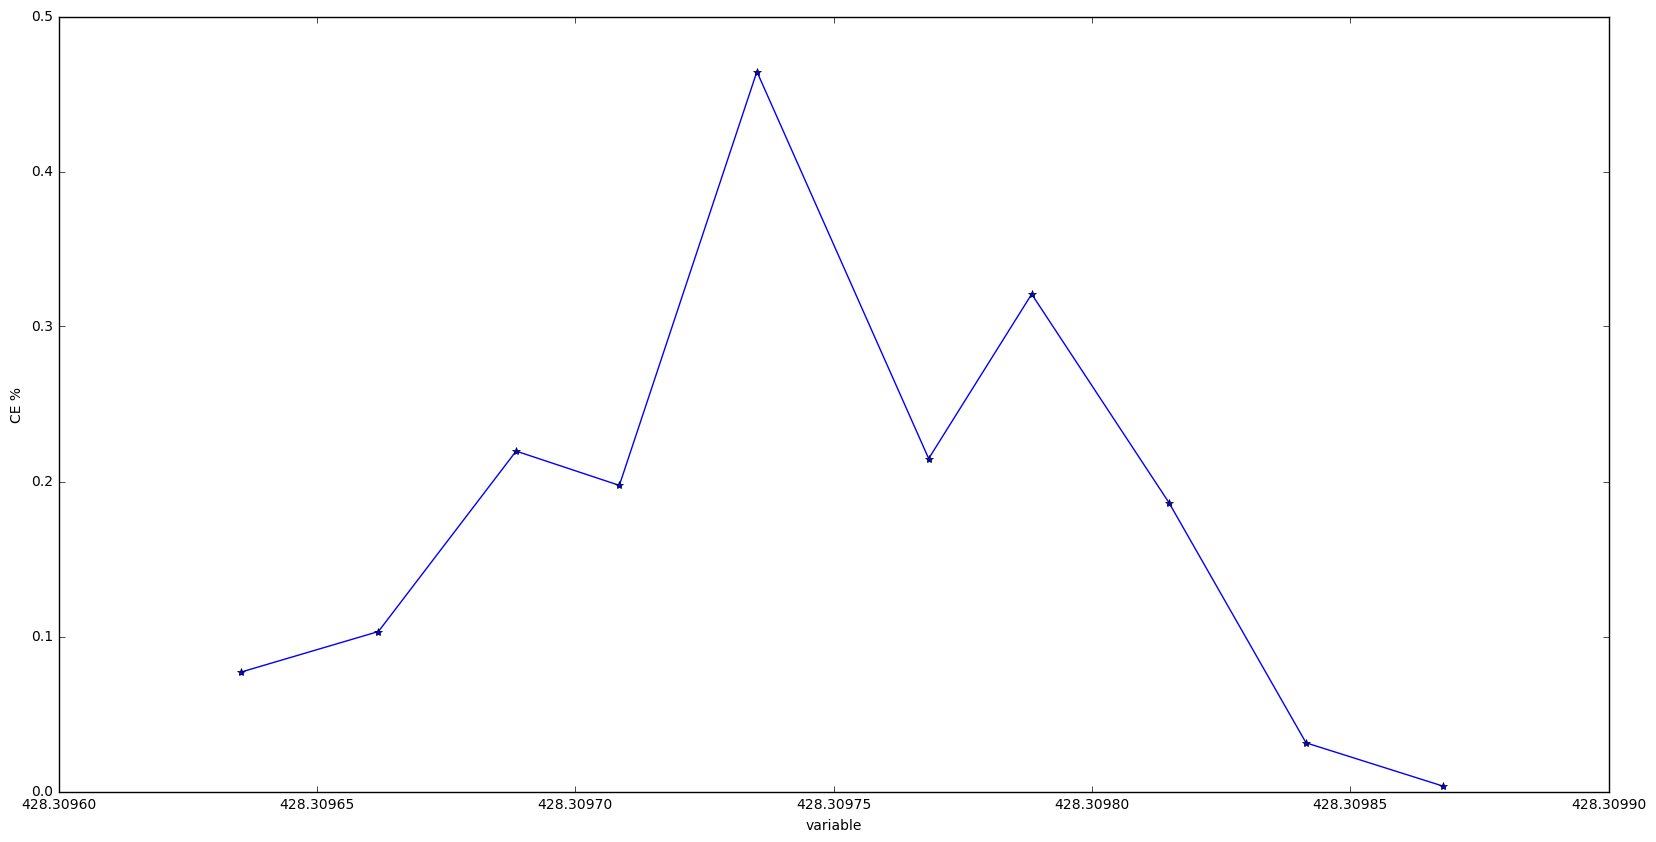

In [22]:
CE.plot_CE('f_p')

In [34]:
tuple(np.arange(1047,1052.1,0.2))


(1047.0,
 1047.2,
 1047.4000000000001,
 1047.6000000000001,
 1047.8000000000002,
 1048.0000000000002,
 1048.2000000000003,
 1048.4000000000003,
 1048.6000000000004,
 1048.8000000000004,
 1049.0000000000005,
 1049.2000000000005,
 1049.4000000000005,
 1049.6000000000006,
 1049.8000000000006,
 1050.0000000000007,
 1050.2000000000007,
 1050.4000000000008,
 1050.6000000000008,
 1050.8000000000009,
 1051.0000000000009,
 1051.200000000001,
 1051.400000000001,
 1051.600000000001,
 1051.8000000000011,
 1052.0000000000011)